In [91]:
setwd('/import/DB/fel/BJTC-204')

In [92]:
exp<- read.table("./00_rawdata/exp.txt",sep = '\t',header = T,row.names = 1) 

In [93]:
load('bulk2.rda')

In [94]:
ls()

[1] "brown_hub_gene"  "exp"             "gene"            "go_bp"          
[5] "groupinfo"       "nmfinput"        "sig_DP_entrezId"

In [95]:
library(readxl)
library(dplyr)

In [96]:
group = read_excel("./00_rawdata/DLPFC_group.xlsx")

In [97]:
group.mdd = groupinfo %>%  tibble::rownames_to_column(.,'Symbol')

In [98]:
group.con = group %>%  dplyr::filter(Group == 'control')

In [99]:
colnames(group.con)[2] = 'group'

In [100]:
group.all = rbind(group.con,group.mdd)

In [101]:
group.all = group.all %>%  tibble::column_to_rownames(.,'Symbol')

In [102]:
control.sample = group.all %>%  dplyr::filter(group == 'control') %>%  rownames(.)

In [103]:
c1.sample = group.all %>%  dplyr::filter(group == 1) %>%  rownames(.)
c2.sample = group.all %>%  dplyr::filter(group == 2) %>%  rownames(.)

In [104]:
control.sample =  exp %>% dplyr::select(control.sample)

In [105]:
c1.sample =  exp %>% dplyr::select(c1.sample)
c2.sample =  exp %>% dplyr::select(c2.sample)

### c1 vs control

In [106]:
data = cbind(control.sample,c2.sample)

In [107]:
group=c(rep("control",length(colnames(control.sample))),rep("cluster2",length(colnames(c2.sample)))) 

In [108]:
library(limma)
library(DESeq2)
library(edgeR)

In [109]:
group_list = factor(group)
design <- model.matrix(~0+group_list)
rownames(design) = colnames(data)
colnames(design) <- levels(group_list)

keep_gene
 TRUE 
11845 

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
XIST,-0.7946200,6.469549,-110.25626,7.197733e-119,8.525715e-115,235.75006
RPS4Y1,0.5801309,6.779971,63.68101,8.446225e-92,5.002277e-88,188.53360
KDM5D,0.3281869,6.713643,32.84358,2.026220e-60,8.000190e-57,124.87435
DDX3Y,0.2936567,6.300243,28.73846,1.898114e-54,5.620791e-51,112.82572
USP9Y,0.3014809,6.235499,19.61816,1.434469e-38,3.398257e-35,77.23000
EIF1AY,0.1448020,6.076863,18.37952,4.373477e-36,8.633972e-33,71.63424


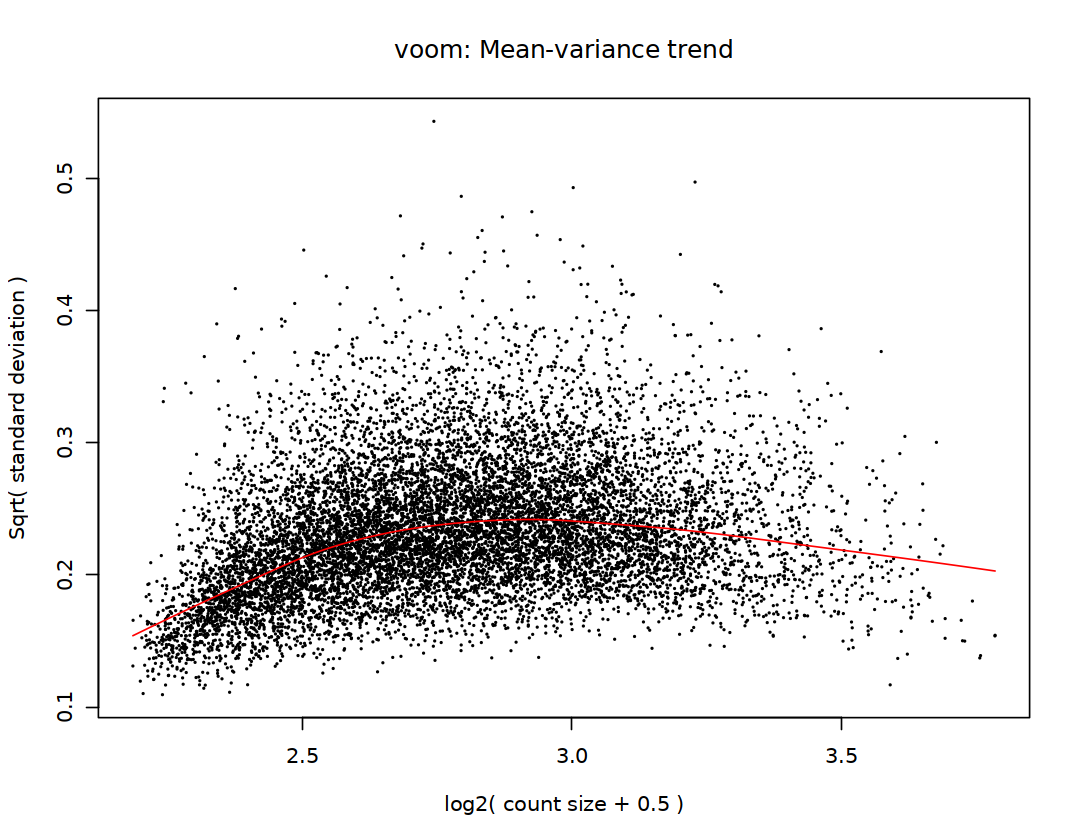

In [110]:
DGElist <- DGEList( counts = data, group = group_list )
keep_gene <- rowSums( cpm(DGElist) > 1 ) >= 1 # 自定义
table(keep_gene)
DGElist <- DGElist[ keep_gene, , keep.lib.sizes = FALSE ]

DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)
cont.matrix <- makeContrasts(contrasts = c('cluster2-control'), levels = design)

fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

nrDEG_limma_voom = topTable(fit2, coef = 'cluster2-control', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)

In [111]:
padj = 0.01 # 自定义
foldChange= 0 # 自定义
nrDEG_limma_voom_signif = nrDEG_limma_voom[(nrDEG_limma_voom$adj.P.Val < padj & 
                          (nrDEG_limma_voom$logFC>foldChange | nrDEG_limma_voom$logFC<(-foldChange))),]
nrDEG_limma_voom_signif = nrDEG_limma_voom_signif[order(nrDEG_limma_voom_signif$logFC),]

In [112]:
dim(nrDEG_limma_voom_signif)

[1] 3243    6

In [113]:
library(cowplot)
    library(pheatmap)
    library(enrichplot)
    library(clusterProfiler)
    library(org.Hs.eg.db)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(geneID = rownames(nrDEG_limma_voom_signif), fromType = "SYMBOL", :
"0.43% of input gene IDs are fail to map..."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


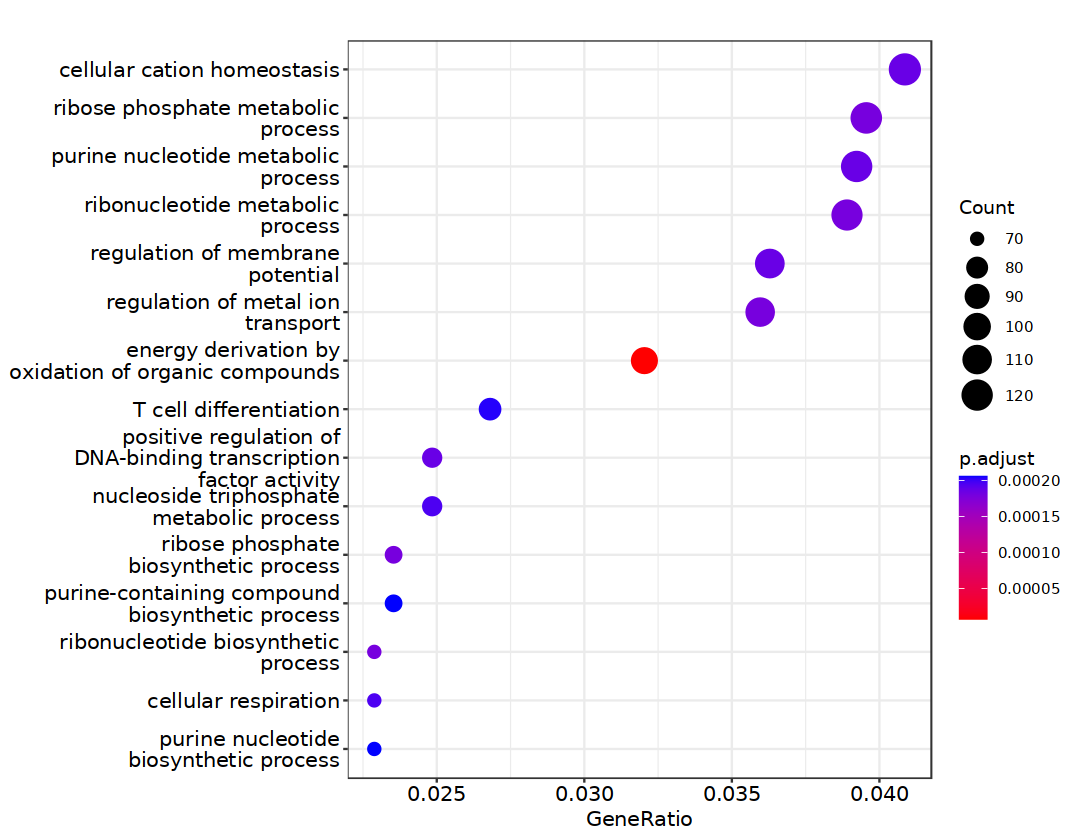

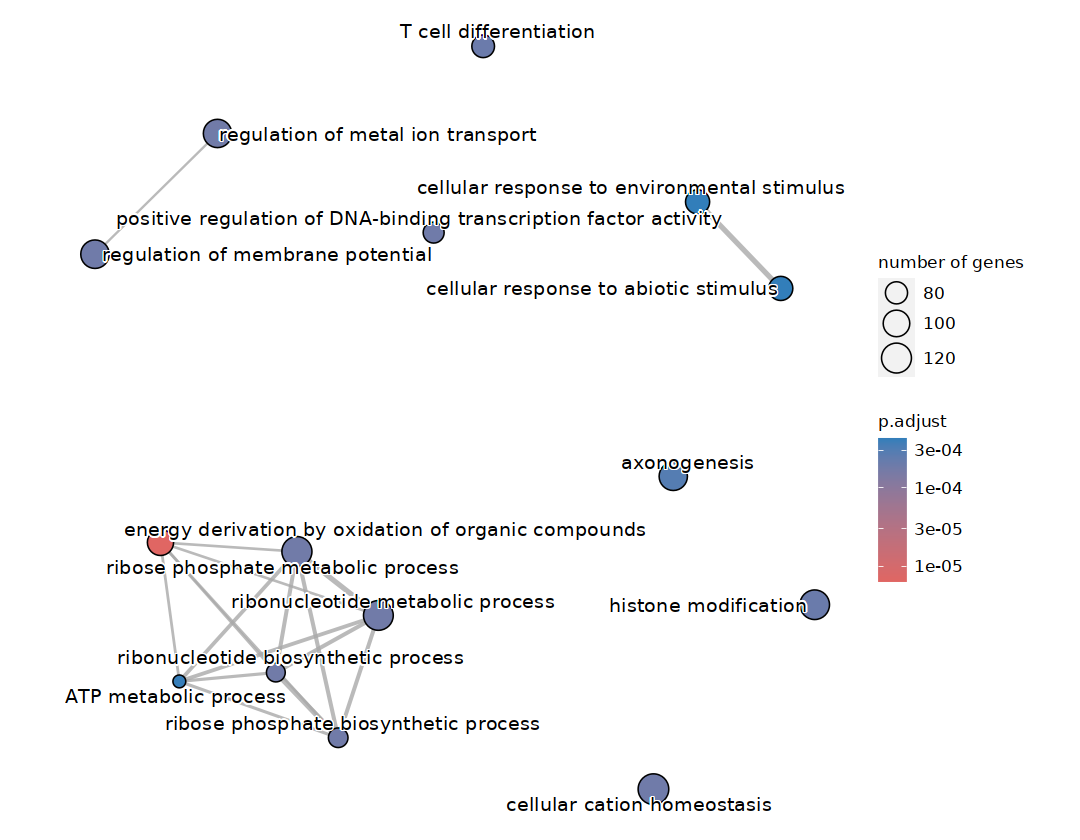

In [114]:
gene_symbol <- bitr(geneID = rownames(nrDEG_limma_voom_signif),  
                        fromType="SYMBOL",   
                        toType=c("ENTREZID"),  
                        OrgDb="org.Hs.eg.db")
    gene <- gene_symbol[,2]
    BP <- enrichGO(gene = gene,  
                   keyType = "ENTREZID",  
                   OrgDb=org.Hs.eg.db,  
                   ont = "BP",   
                   pvalueCutoff = 0.05,  
                   pAdjustMethod = "fdr", 
                   minGSSize = 5,   
                   maxGSSize = 500,  
                   qvalueCutoff = 0.05,  
                   readable = TRUE)  
    
    dotplot(BP,showCategory = 15)
    #ggsave('GO_enrichment_dotplot.pdf',height = 15,width = 8)
    bp <-clusterProfiler::simplify(BP)
    BP_ego <- enrichplot::pairwise_termsim(bp)
    emapplot(BP_ego, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('GO_enrichment_emapplot.pdf',height = 15,width = 8)
    df <- BP_ego@result
   # write.csv(df ,file = 'GO_results.csv')

Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


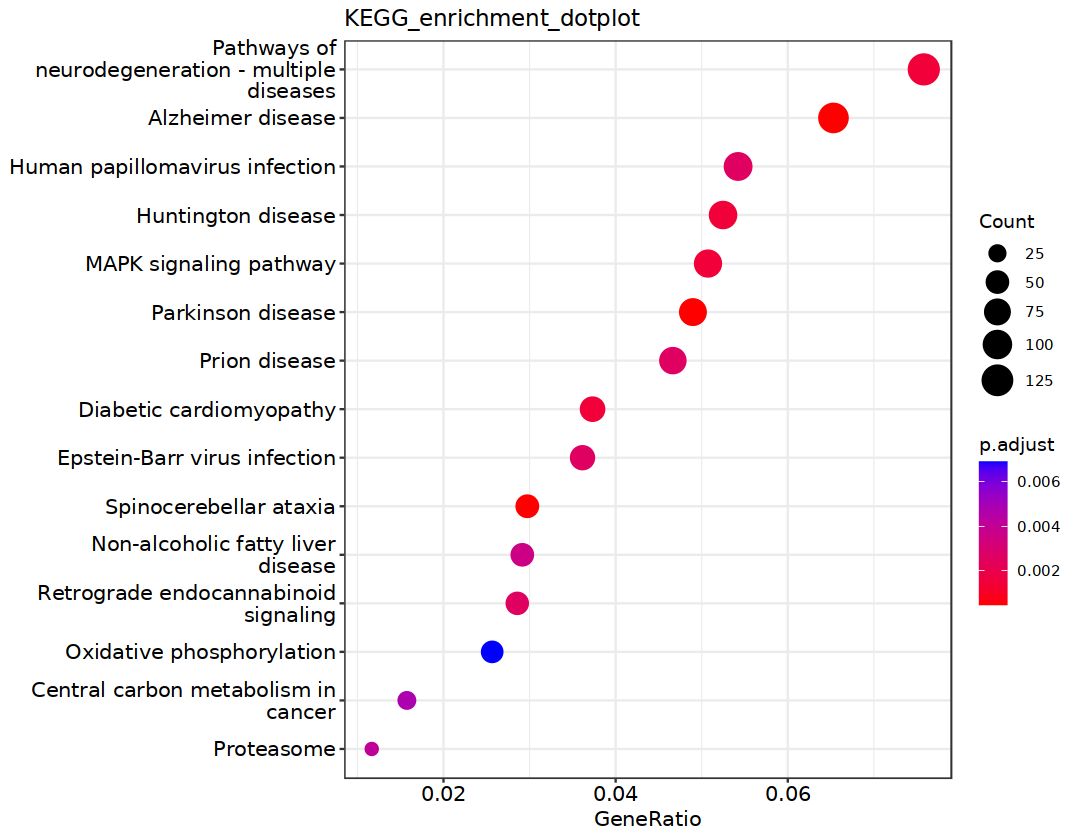

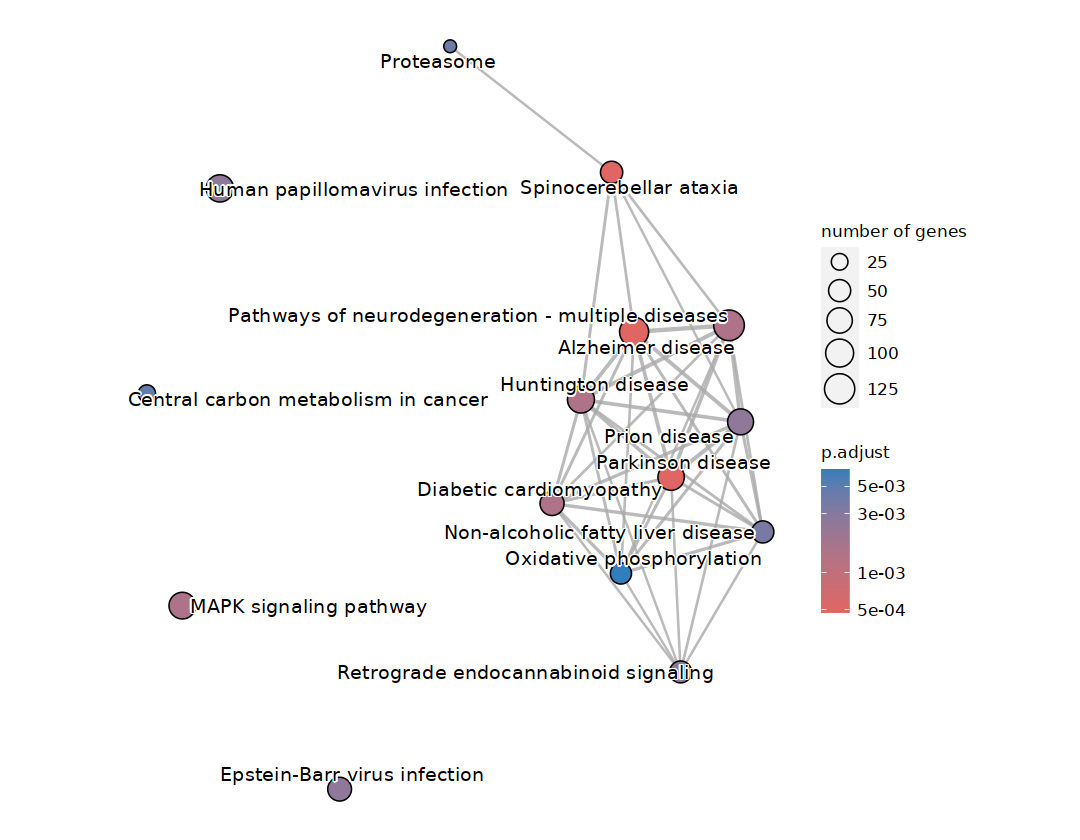

In [115]:
ek <- enrichKEGG(gene =gene , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
   # ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
   # ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)  

In [116]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Allowing parallel execution with up to 255 working processes.


In [117]:
group.all1 = group.all %>% filter(group != 'control')

In [118]:
exp1 = exp[,rownames(group.all1)]

In [119]:
dataExpr = exp1

In [120]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.01)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [121]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [122]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]  118 8883

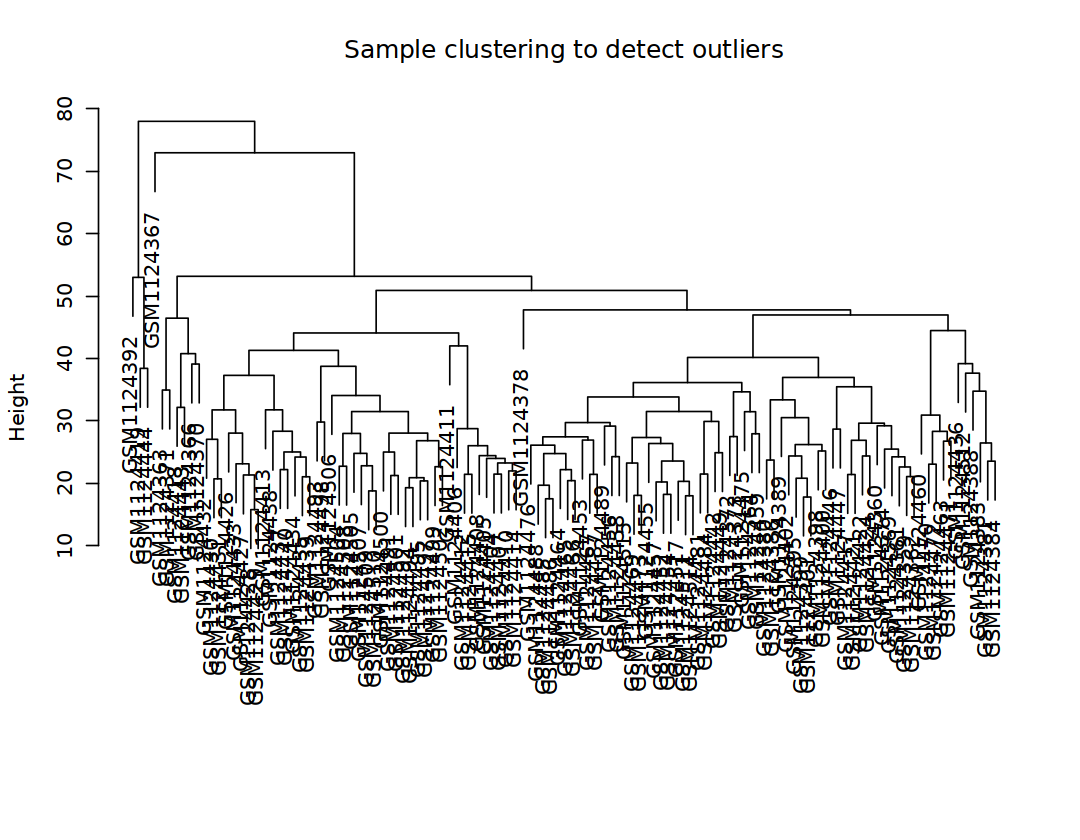

In [123]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [124]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 5036.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5036 of 8883
   ..working on genes 5037 through 8883 of 8883
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.  max.k.
1      1   0.4990  1.760          0.926 2690.000  2.74e+03 4260.00
2      2   0.0177 -0.152          0.721 1160.000  1.12e+03 2550.00
3      3   0.4350 -0.902          0.780  590.000  5.25e+02 1670.00
4      4   0.6020 -1.200          0.855  330.000  2.66e+02 1160.00
5      5   0.6780 -1.360          0.899  198.000  1.43e+02  828.00
6      6   0.7290 -1.440          0.934  124.000  8.11e+01  609.00
7      7   0.7550 -1.500          0.949   81.400  4.72e+01  457.00
8      8   0.7790 -1.550          0.962   54.900  2.86e+01  350.00
9      9   0.7890 -1.600          0.965   38.000  1.77e+01  272.00
10    10   0.8010 -1.620          0.972   27.000  1.13e+01  214.00
11    12   0.8360 -1.640          0.981   14.300  4.75e+00  

In [125]:
options(repr.plot.width = 9)

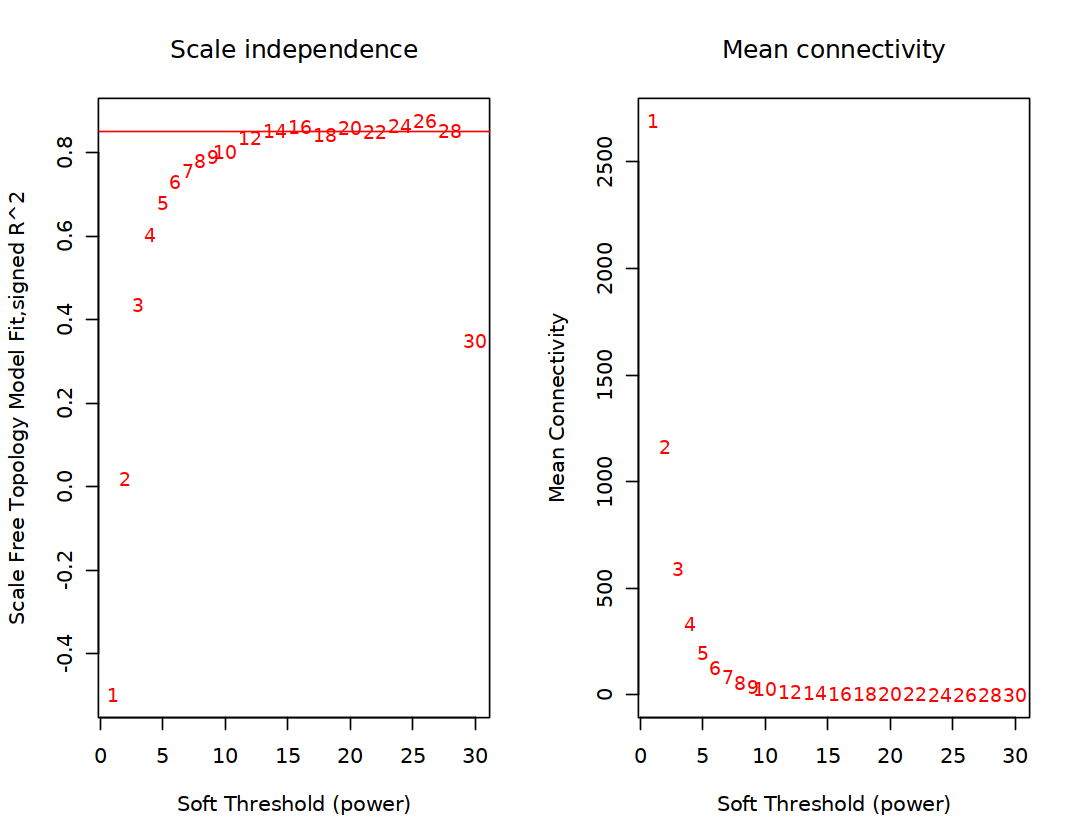

In [126]:
par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [127]:
power = sft$powerEstimate
power

[1] 14

In [128]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [129]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ./fpkm.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
 ..merging modules that are too close..
     mergeCloseModules: Merging modules whose distance is less than 0.25
       Calculating new MEs...


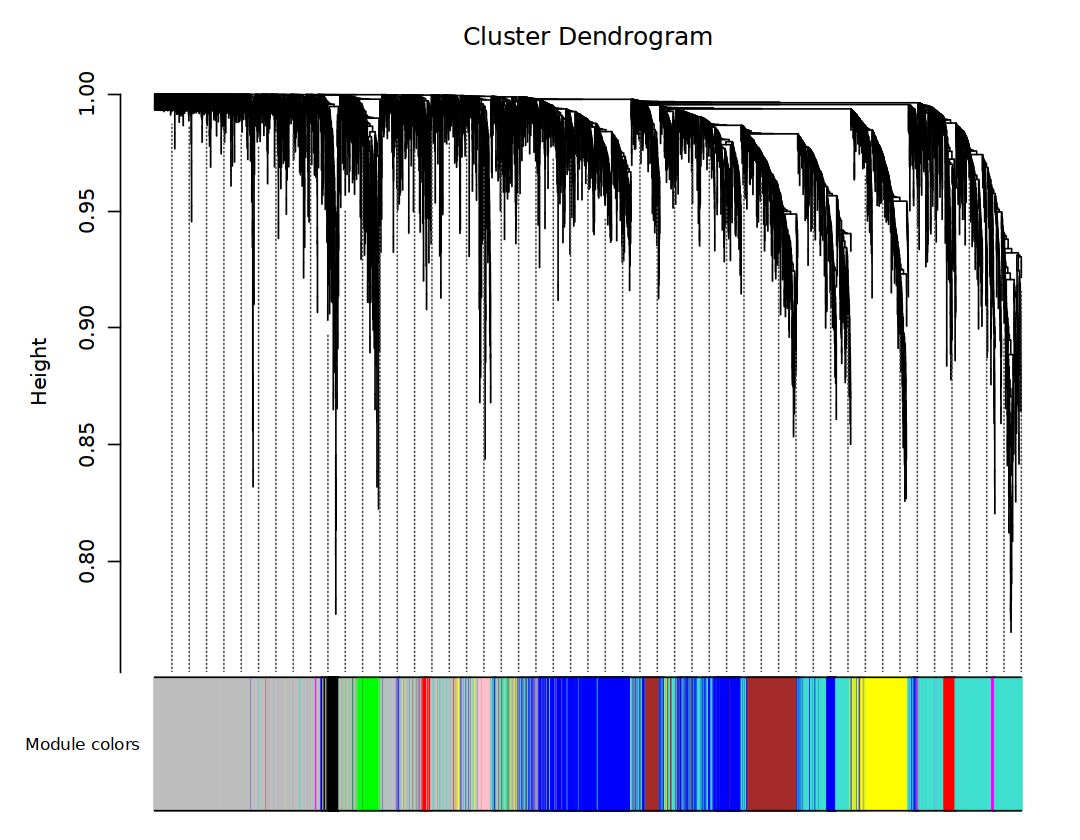

In [130]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [131]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

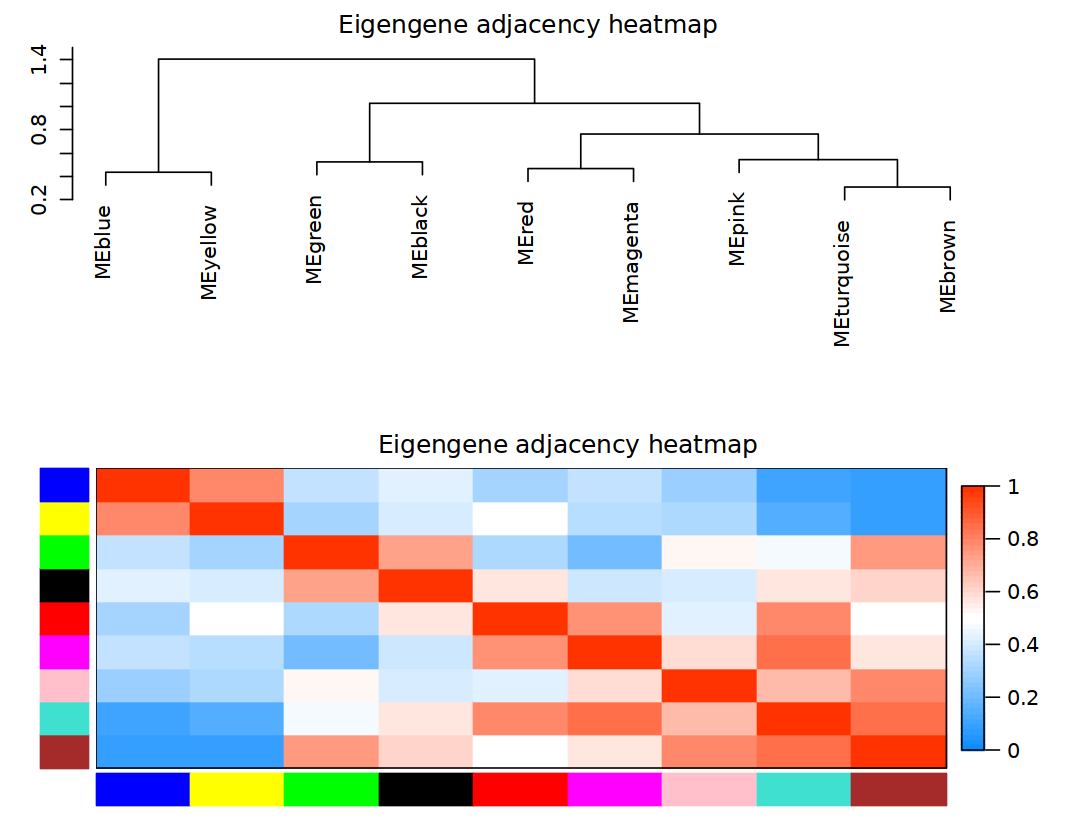

In [132]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [133]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [134]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [135]:
design <- model.matrix(~0 + group.all1$group)
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))
design <- design[rownames(MEs_col),]

# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [136]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


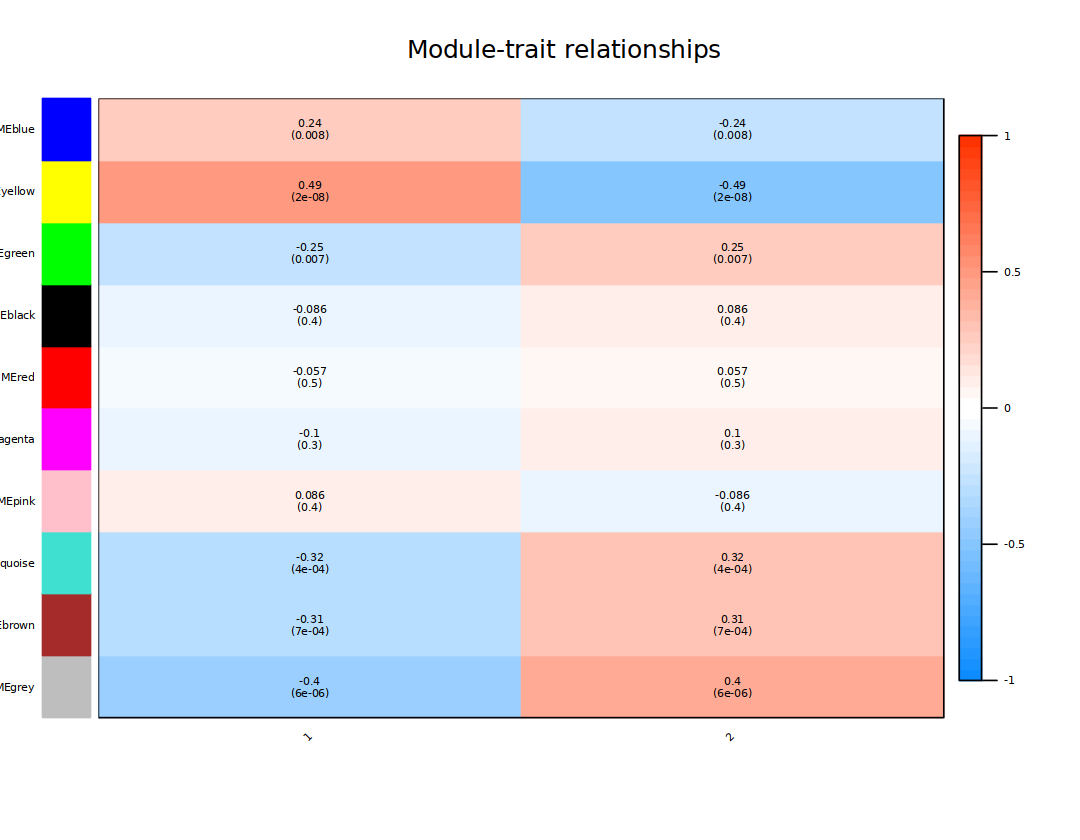

In [137]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 0.5,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 0.5,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [138]:
dat = dataExpr

In [139]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [140]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [141]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

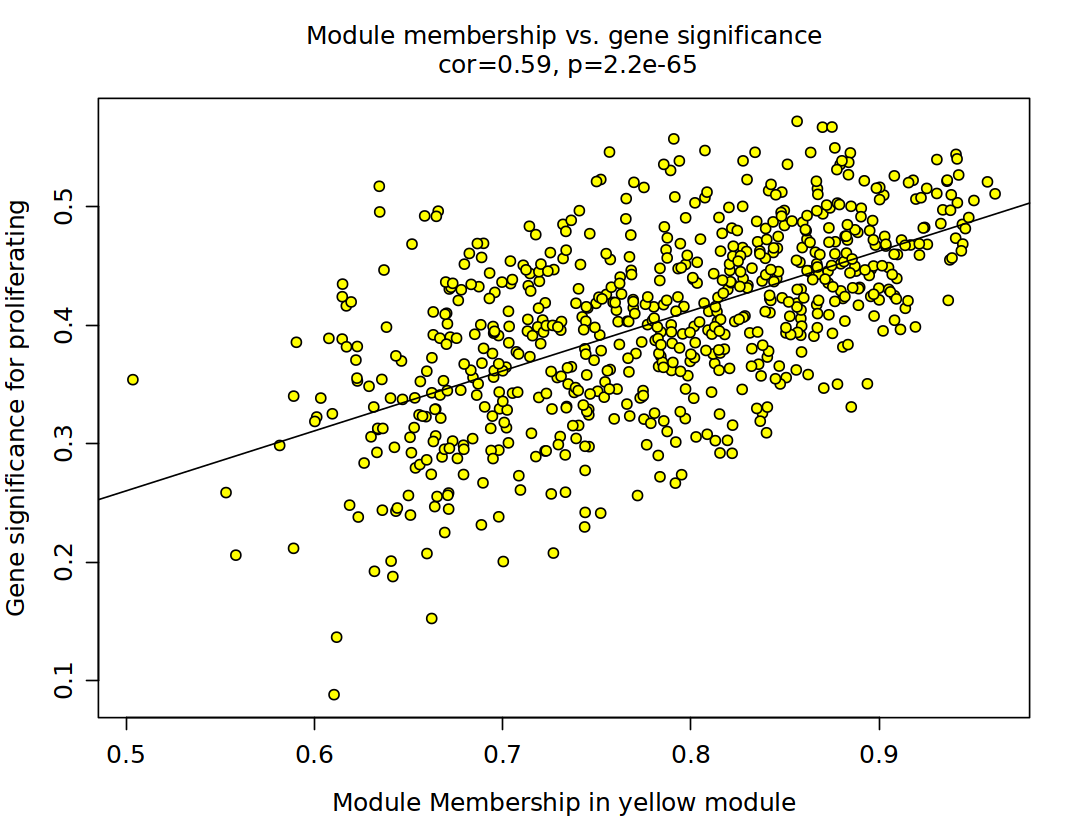

In [182]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

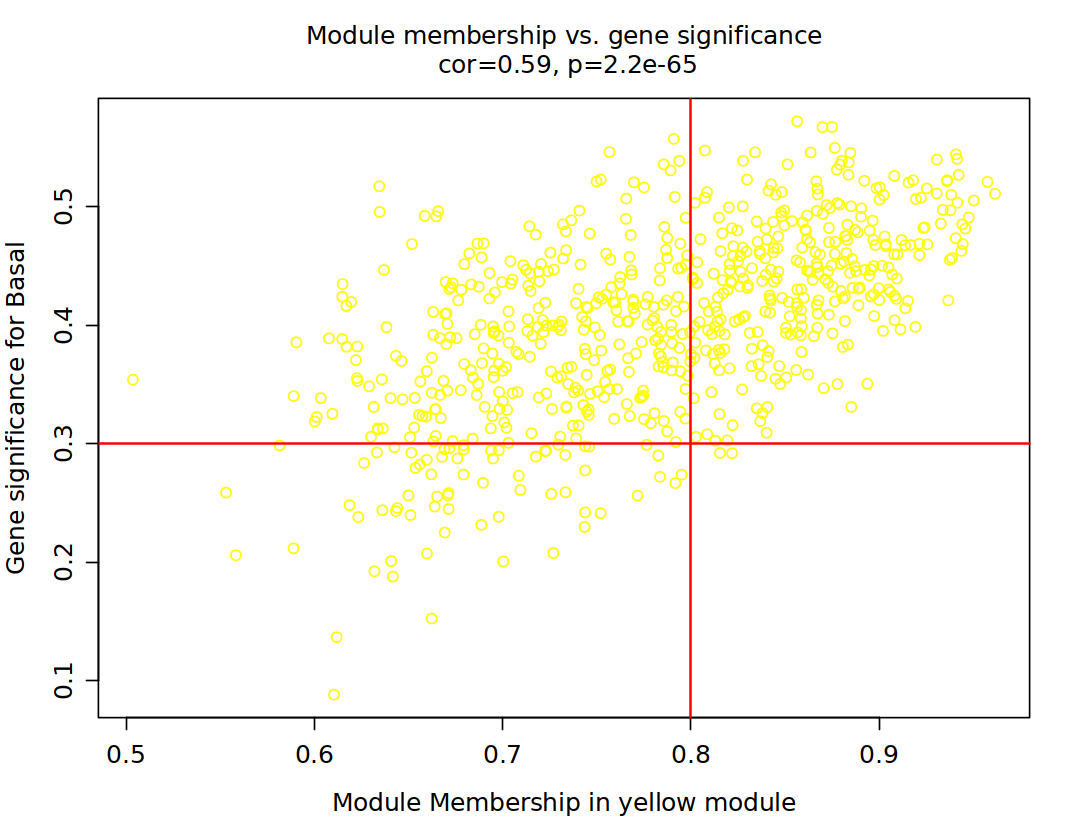

In [166]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [173]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

[1] 307

In [174]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [175]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


'select()' returned 1:1 mapping between keys and columns



In [176]:
table(is.na(sig_DP_entrezId))


FALSE  TRUE 
  305     2 

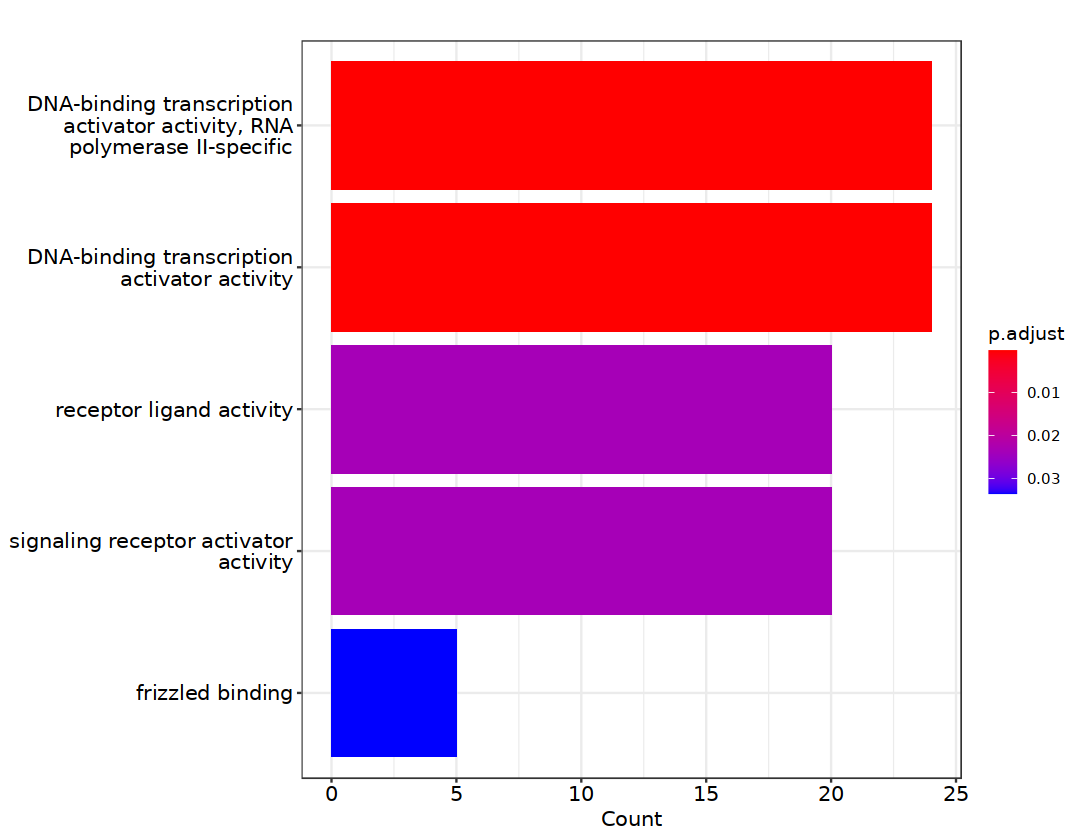

In [177]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


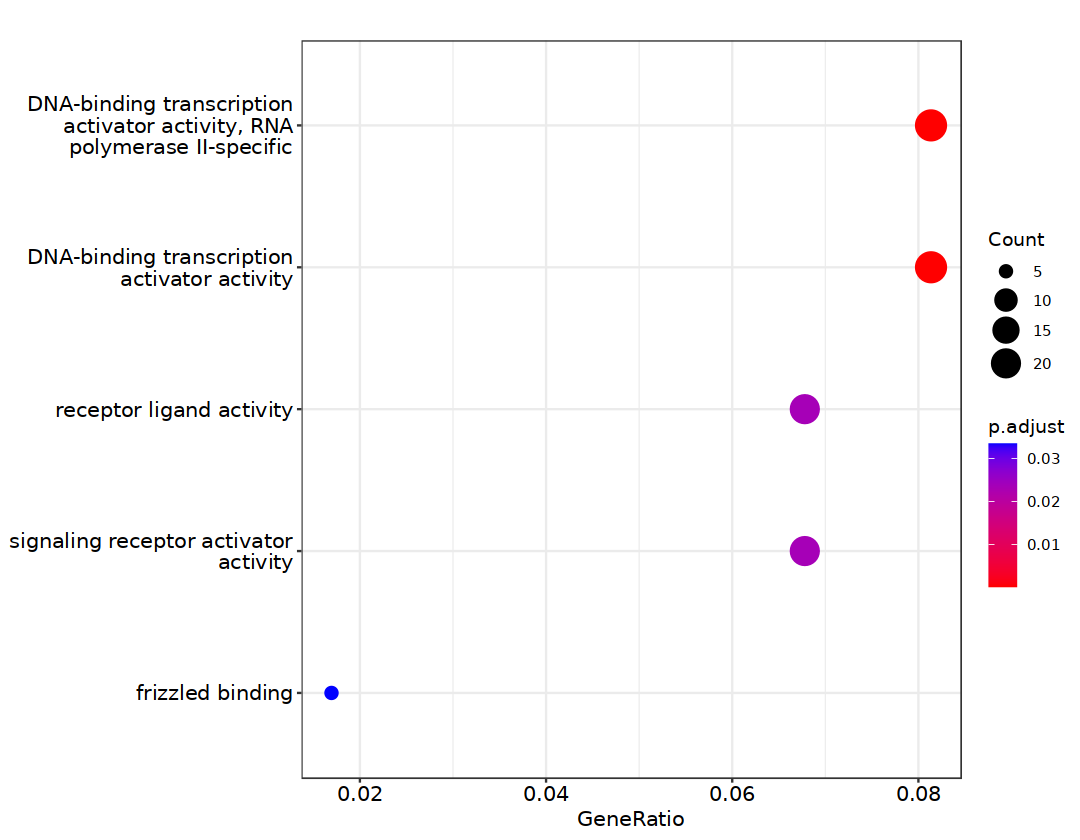

In [179]:
#画图
dotplot(go_bp)

Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(category_label = your_value)' instead of 'cex_label_category'.
 The cex_label_category parameter will be removed in the next version."
Warning message in emapplot.enrichResult(x, showCategory = showCategory, ...):
"Use 'cex.params = list(line = your_value)' instead of 'cex_line'.
 The cex_line parameter will be removed in the next version."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


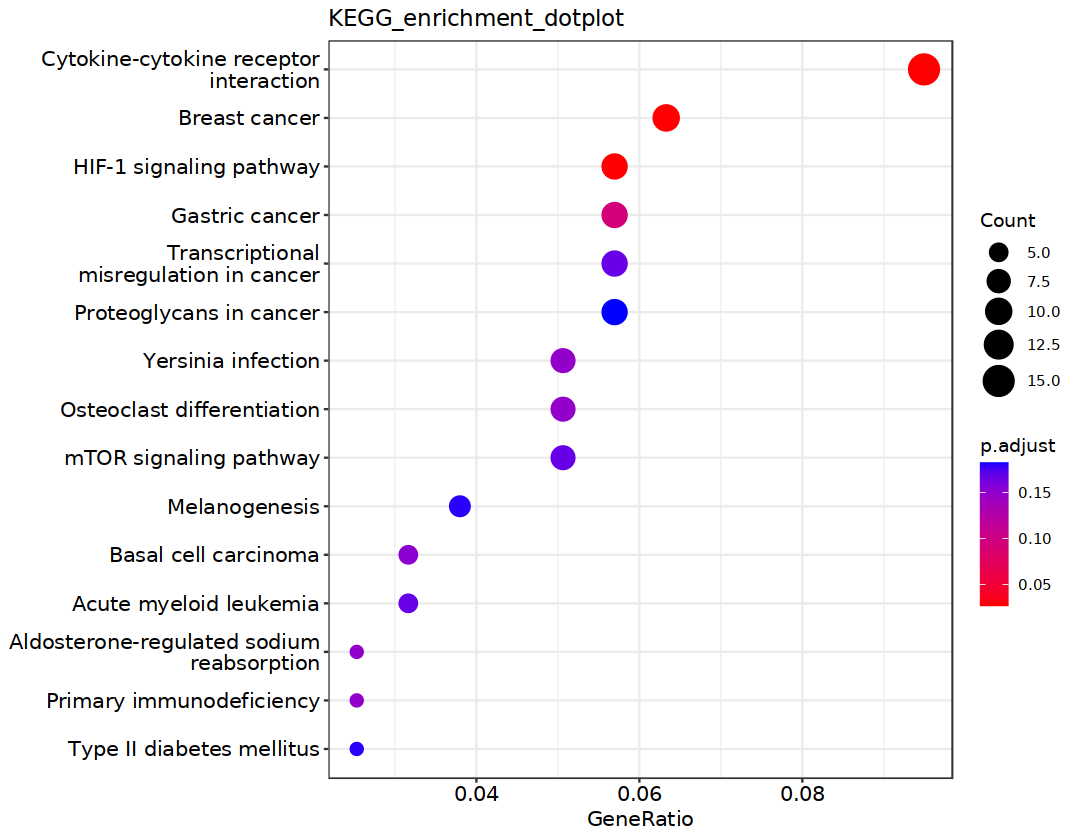

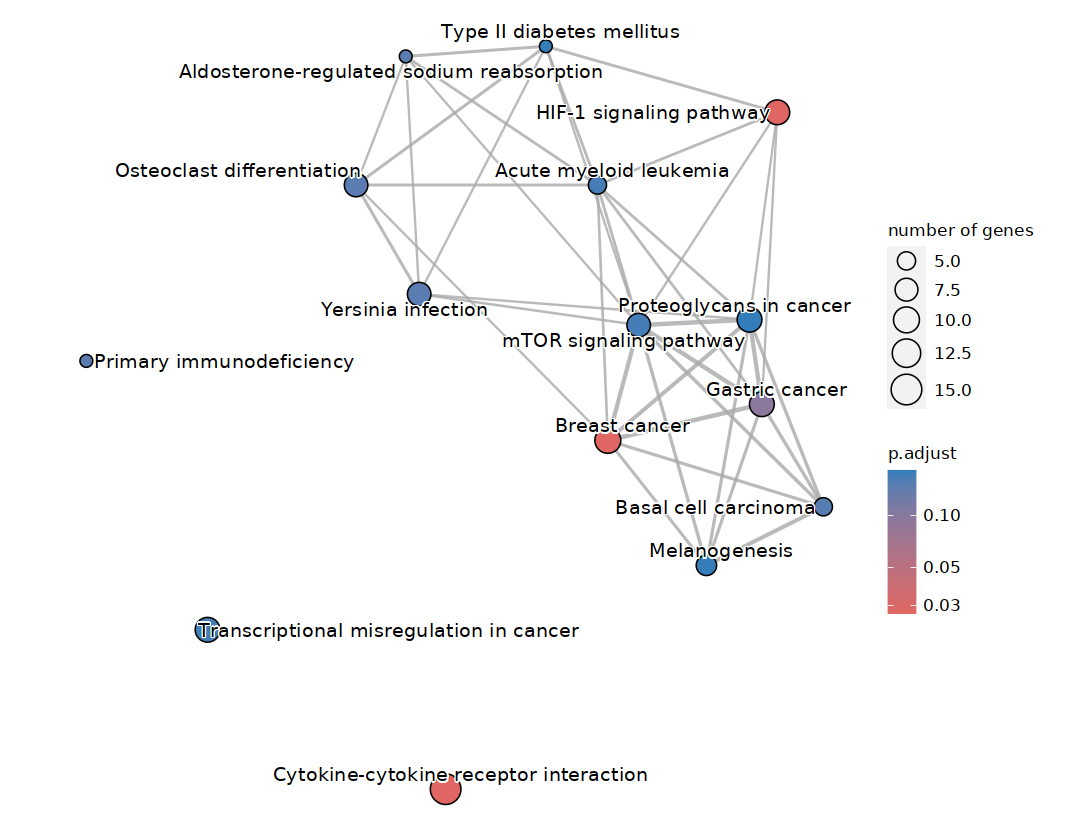

In [180]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   